# LFP Analysis

This notebook will demonstrate how to access and analyze LFP data from the Dynamic Gating dataset. LFP, which stands for "local field potential," contains information about low-frequency (0.1-500 Hz) voltage fluctations around each recording site. It's complementary to the spiking activity, and can be analyzed on its own or in conjunction with spikes.

In [1]:
import pynwb
from allensdk.brain_observatory.ecephys.dynamic_gating_ecephys_session import DynamicGatingEcephysSession
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

To load the LFP, we provide a mapping of the probe name to the corresponding LFP nwb. The LFP data is in a seperate nwb to speed up processing since the LFP data is quite large. The example below shows an example of providing such a mapping. As seen in the other notebooks, we just use the data asset and provide the paths.

In [118]:
session = '1183071525'
# CHANGE TO CORRESPONDING PATH
probe_map = {
    'probeA': '../data/nwb/{}/{}_lfp_probeA.nwb'.format(session, session),
    'probeB': '../data/nwb/{}/{}_lfp_probeB.nwb'.format(session, session),
    'probeC': '../data/nwb/{}/{}_lfp_probeC.nwb'.format(session, session),
    'probeD': '../data/nwb/{}/{}_lfp_probeD.nwb'.format(session, session),
    'probeE': '../data/nwb/{}/{}_lfp_probeE.nwb'.format(session, session),
    'probeF': '../data/nwb/{}/{}_lfp_probeF.nwb'.format(session, session)
}

nwb_file_asset = pynwb.NWBHDF5IO('../data/nwb/{}/{}.nwb'.format(session, session), mode='r', load_namespaces=True)
nwb_file = nwb_file_asset.read()
dynamic_gating_session = DynamicGatingEcephysSession.from_nwb(nwb_file, probe_map)

Now to access the LFP for a probe, we call the get_lfp function giving it the probe id. The probes data below shows the ids for this session. Note the lfp portion is empty since we have not loaded any LFP yet. Again this is done on the fly to speed up processing

In [119]:
dynamic_gating_session.probes

,name,location,sampling_rate,lfp_sampling_rate,has_lfp_data
id,,,,,
41,probeA,See electrode locations,30000.131455,None,False
42,probeB,See electrode locations,29999.952958,None,False
43,probeC,See electrode locations,30000.224639,None,False
44,probeD,See electrode locations,30000.109926,None,False
45,probeE,See electrode locations,30000.073777,None,False
46,probeF,See electrode locations,30000.127438,None,False


Now lets look at the lfp for a probe

In [120]:
lfp = dynamic_gating_session.get_lfp(42)

If we look at the probes table now, the lfp information is there after loading it

In [121]:
dynamic_gating_session.probes

,name,location,sampling_rate,lfp_sampling_rate,has_lfp_data
id,,,,,
41,probeA,See electrode locations,30000.131455,NaN,False
42,probeB,See electrode locations,29999.952958,2499.99608,True
43,probeC,See electrode locations,30000.224639,NaN,False
44,probeD,See electrode locations,30000.109926,NaN,False
45,probeE,See electrode locations,30000.073777,NaN,False
46,probeF,See electrode locations,30000.127438,NaN,False


Lets take a look at the contents of the lfp

In [122]:
lfp

<xarray.DataArray 'LFP' (time: 7871352, channel: 92)>
array([[ 2.65200e-05,  3.15900e-05,  5.12850e-05, ..., -1.75500e-06,
        -4.48500e-06, -3.70500e-06],
       [ 1.22850e-05,  8.97000e-06,  1.93050e-05, ...,  2.30100e-05,
        -3.27600e-05, -2.20350e-05],
       [-1.50150e-05,  3.12000e-06,  2.59350e-05, ...,  2.86650e-05,
        -4.48500e-06, -1.38450e-05],
       ...,
       [ 2.08845e-04,  2.40045e-04,  1.20315e-04, ..., -5.20650e-05,
         1.65750e-05, -2.14500e-06],
       [ 2.22495e-04,  2.14890e-04,  1.20315e-04, ..., -4.34850e-05,
         1.91100e-05, -1.36500e-06],
       [ 1.73940e-04,  1.70040e-04,  1.14855e-04, ..., -2.47650e-05,
         1.54050e-05, -1.07250e-05]], dtype=float32)
Coordinates:
  * time     (time) float64 4.742 4.743 4.744 ... 6.302e+03 6.302e+03 6.302e+03
  * channel  (channel) int64 16130 16134 16138 16142 ... 16482 16486 16490 16494

The LFP data is stored as an xarray.DataArray object, with coordinates of time and channel. The xarray library simplifies the process of working with N-dimensional data arrays, by keeping track of the meaning of each axis. If this is your first time encountering xarrays, we strongly recommend reading through the documentation before going further. Getting used to xarrays can be frustrating, especially when they don't behave like numpy arrays. But they are designed to prevent common mistakes when analyzing multidimensional arrays, so they are well worth learning more about. Plus, the syntax is modeled on that of the pandas library, so if you're familiar with that you already have a head start.

Let's use the DataArray.sel() method to select a slice through this array between 100 and 101 seconds:

In [123]:
lfp_slice = lfp.sel(time=slice(100, 101))

lfp_slice

<xarray.DataArray 'LFP' (time: 1250, channel: 92)>
array([[-6.0449997e-06,  3.1590000e-05,  1.1349000e-04, ...,
         1.3260000e-05, -2.8470000e-05, -2.7885000e-05],
       [-2.1450001e-06,  1.4235000e-05,  9.2625000e-05, ...,
         0.0000000e+00, -1.4820000e-05, -9.9449999e-06],
       [ 3.2954998e-05,  3.9585000e-05,  1.0237500e-04, ...,
         0.0000000e+00,  1.1700000e-06, -1.2675000e-05],
       ...,
       [-8.9895002e-05,  9.1649999e-06, -7.7414996e-05, ...,
         2.5154999e-05,  7.9949996e-06, -1.8524999e-05],
       [-1.3396500e-04, -8.5800002e-06, -1.0647000e-04, ...,
         4.0560000e-05, -3.9000001e-06, -1.5600001e-05],
       [-1.8349499e-04, -5.8304999e-05, -1.8583500e-04, ...,
         1.2870000e-05,  2.4375000e-05,  7.7999999e-07]], dtype=float32)
Coordinates:
  * time     (time) float64 100.0 100.0 100.0 100.0 ... 101.0 101.0 101.0 101.0
  * channel  (channel) int64 16130 16134 16138 16142 ... 16482 16486 16490 16494

We see that this new DataArray is smaller than before; it contains the same number of channels, but only 1250 samples, due to the LFP sample rate of ~1250 Hz.

Let's plot the data for one of the channels:

Text(0, 0.5, 'LFP (V)')

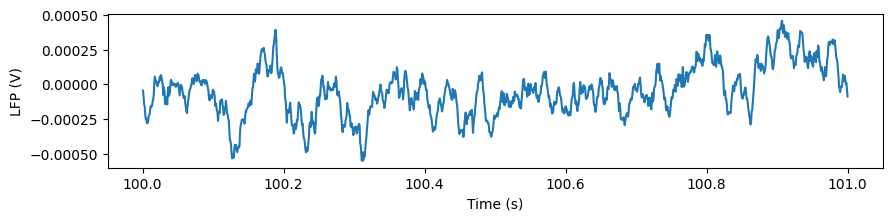

In [124]:
plt.figure(figsize=(10,2))
_ = plt.plot(lfp_slice.time, lfp_slice.sel(channel=lfp_slice.channel[10]))
plt.xlabel('Time (s)')
plt.ylabel('LFP (V)')

Alternatively, we can visualize this slice of data using matplotlib's imshow method:

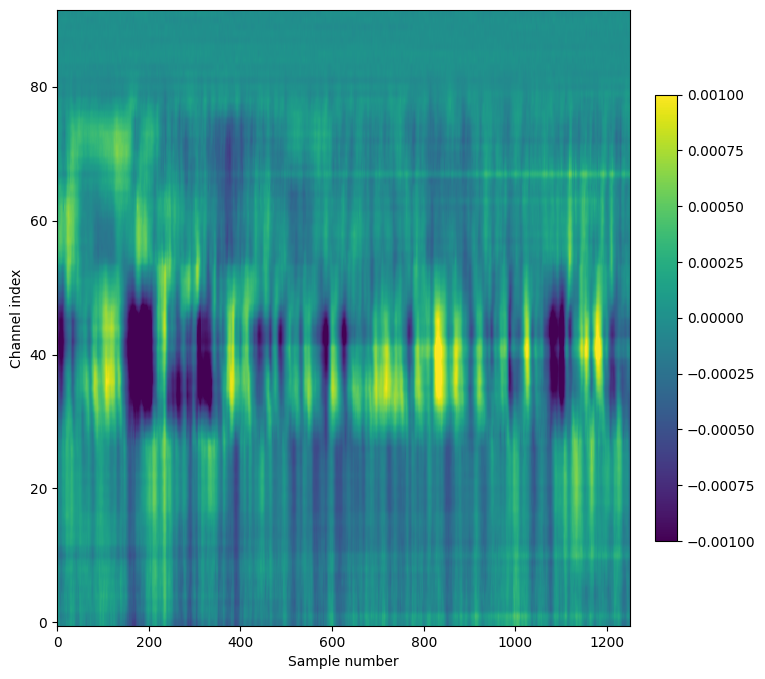

In [125]:
plt.figure(figsize=(8,8))
im = plt.imshow(lfp_slice.T,aspect='auto',origin='lower',vmin=-1e-3, vmax=1e-3)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Sample number')
_ = plt.ylabel('Channel index')

Note that we've transposed the original array to place the time dimension along the x-axis. We've also configured the plot so that the origin of the array is in the lower-left, so that that channels closer to the probe tip are lower in the image.

A few things to note about this plot:
* The units of the LFP are volts, so the color scale ranges from -1 to +1 mV
* Even though there are 384 channels on the Neuropixels probe, there are only 96 channels in this plot. That's because only every 4th channel is included in the NWB file (resulting in 40 micron vertical spacing). In addition, the reference channels and channels far outside the brain have been removed.
* The top of the plot is relatively flat. This corresponds to channels that are outside the brain. The LFP channels are originally referenced to the tip reference site on the Neuropixels probe. Before NWB packaging, the LFP data is digitally referenced to the channels outside the brain.


# Aliging LFP Data to Stimulus

In the above example, we selected LFP data based on an arbitrary time span (100 to 101 seconds). For many analyses, however, you'll want to align the data to the onset of a particular type of stimulus.

In [126]:
stim_presentations = dynamic_gating_session.stimulus_presentations
flashes = stim_presentations[stim_presentations['stimulus_name'].str.contains('flash')]
presentation_times = flashes.start_time.values
presentation_ids = flashes.index.values

First, let's make a convenience function that helps us align the LFP to times of interest. Because we're using xarrays, the alignment operation is fast, and doesn't require any for loops! There's a lot going on here, so we recommend referring to the pandas and xarray documentation if anything is confusing:

In [127]:
def align_lfp(lfp, trial_window, alignment_times, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([trial_window + t for t in alignment_times])
    
    if trial_ids is None:
        trial_ids = np.arange(len(alignment_times))
        
    inds = pd.MultiIndex.from_product((trial_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
    ds = ds.assign(time=inds).unstack('time')

    return ds['aligned_lfp']

In [128]:
aligned_lfp = align_lfp(lfp, np.arange(-0.5, 0.5, 1/500), presentation_times, presentation_ids)

aligned_lfp is a DataArray with dimensions of channels x trials x time. It's been downsampled to 500 Hz by changing the time step in the trial_window argument of the align_lfp function.

Note that we can get the channels IDs for each channel in this DataArray. Let's use the session channels table to map these to the probe and mark the surface of the brain.

In [129]:
chans = dynamic_gating_session.get_channels()
lfp_chan_depths = [chans.loc[c]['probe_vertical_position'] for c in lfp.channel.values]

chans_in_brain = chans[(chans['probe_id']==42)&(~chans['structure_acronym'].str.contains('No Area'))&(~chans['structure_acronym'].str.contains('out of brain'))]
first_channel_in_brain_position = chans_in_brain['probe_vertical_position'].max()
first_channel_in_brain_position

3320

<ipython-input-130-ff6175ee103a>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(aligned_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_lfp.mean(dim='presentation_id').data)


Text(-0.4, 3370, 'brain surface')

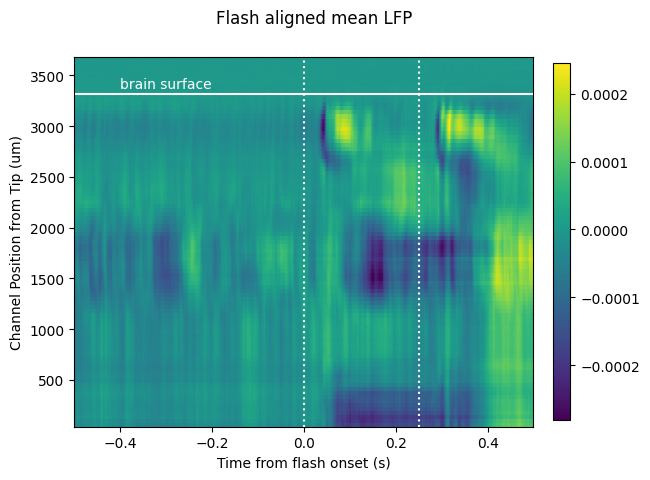

In [130]:
fig, ax = plt.subplots()
fig.suptitle('Flash aligned mean LFP')
im = ax.pcolor(aligned_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_lfp.mean(dim='presentation_id').data)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Time from flash onset (s)')
_ = plt.ylabel('Channel Position from Tip (um)')

ax.axvline(0, c='w', ls='dotted')
ax.axvline(0.25, c='w', ls='dotted')
ax.axhline(first_channel_in_brain_position, c='w')
ax.text(-0.4, first_channel_in_brain_position+50, 'brain surface', c='w')

# Aligning LFP data to units

The previous section demonstrated how to align the LFP in time. What if we want to extract the LFP at a particular location in space, corresponding to the location of a unit we're analyzing?

Let's start by finding a well-isolated unit whose peak channel is included in our LFP data.

Once we've selected a unit of interest, we can align the LFP data to its spike times:


In [131]:
sess_units  = dynamic_gating_session.get_units()

#Grab units whose peak channels are in the LFP data, have relatively low isi violations and high amplitude spikes
units_on_lfp_chans = sess_units[(sess_units.peak_channel_id.isin(lfp.channel.values)) &
                                (sess_units.isi_violations < 0.5) &
                                (sess_units.amplitude > 200)]

#Merge this curated unit table with the channel table to get CCF locations for these units
units_on_lfp_chans = units_on_lfp_chans.merge(chans, left_on='peak_channel_id', right_index=True)
units_on_lfp_chans.structure_acronym

id
15368     LGv
15370     LGv
15371     LGv
15378     IGL
15388     LGd
15585     LGd
15397     LGd
15416     LGd
15417     LGd
15430     CA3
15438     CA3
15439     CA3
15440     CA3
15591     CA3
15607     CA3
15446     CA3
15447     CA3
15448     CA3
15450     CA3
15454     CA3
15457     CA3
15481     CA1
15488     CA1
15510     CA1
15512     CA1
15518    VISp
15519    VISp
15527    VISp
15539    VISp
15545    VISp
15550    VISp
15551    VISp
15557    VISp
15602    VISp
15601    VISp
Name: structure_acronym, dtype: object

In [132]:
#Select a unit
area_units = units_on_lfp_chans[units_on_lfp_chans.structure_acronym.str.contains('VISp')]
unit_id = area_units.index.values[5]

#Get the peak channel ID for this unit (the channel on which it had the greatest spike amplitude)
peak_chan_id = units_on_lfp_chans.loc[unit_id]['peak_channel_id']
peak_probe_position = units_on_lfp_chans.loc[unit_id]['probe_vertical_position']

area_units.index.size

10

In [133]:
start_time = 1920
end_time = 1930

spike_times = dynamic_gating_session.spike_times[unit_id]

times_in_range = spike_times[(spike_times > start_time) & (spike_times < end_time)]

lfp_data = lfp.sel(time = slice(start_time, end_time))
lfp_data = lfp_data.sel(channel = peak_chan_id, method='nearest')

dynamic_gating_session.spike_times[unit_id]

array([5.37766663e+00, 5.48133346e+00, 5.52453353e+00, ...,
       6.30173437e+03, 6.30174994e+03, 6.30181797e+03])

Let's also find the stimulus presentations in this window

In [134]:
stims_in_window = stim_presentations[(stim_presentations.start_time>start_time)&(stim_presentations.start_time<end_time) &
                                    (stim_presentations.omitted==False)]
stim_times_in_window = stims_in_window.start_time.values

Finally, we can plot the spike times and stim times along with the LFP for this interval:

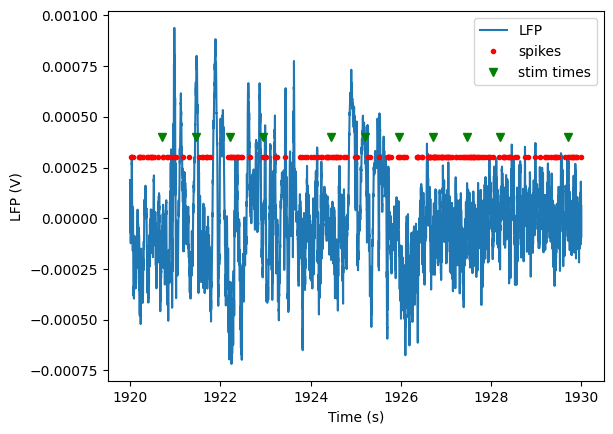

In [135]:
_ = plt.plot(lfp_data.time, lfp_data)
_ = plt.plot(times_in_range, np.ones(times_in_range.shape)*3e-4, '.r')
_ = plt.xlabel('Time (s)')
_ = plt.ylabel('LFP (V)')

_ = plt.plot(stim_times_in_window, np.ones(stim_times_in_window.size)*4e-4, 'vg')

plt.legend(['LFP', 'spikes', 'stim times'])

Now let's calculate a spike triggered average of the LFP using a subset of spikes for our unit of interest and the align_lfp function we defined above:

In [136]:
rng = np.random.default_rng(seed=42) #set seed for deterministic results
spikes_to_use = rng.choice(spike_times, min((spike_times.size, 1000)), replace=False)
spike_triggered_lfp = align_lfp(lfp, np.arange(-0.1, 0.1, 1/1250), spikes_to_use)

Let's plot this spike-triggered LFP for a region of the probe centered on this unit's peak channel

Text(0, 0.5, 'Channel depth')

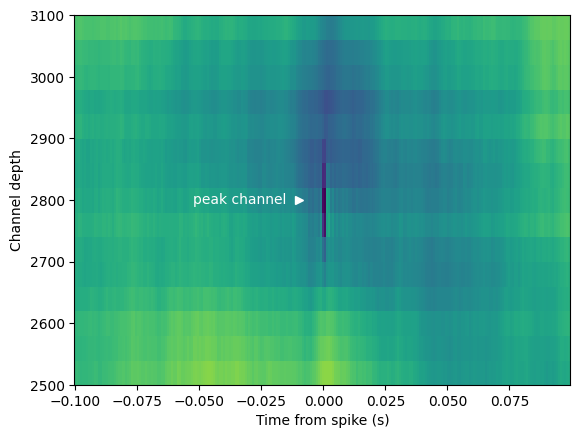

In [137]:
fig, ax = plt.subplots()
im = ax.pcolor(spike_triggered_lfp.time_from_presentation_onset.values, lfp_chan_depths, 
               spike_triggered_lfp.mean(dim='presentation_id').data, shading='auto')

ax.plot(-0.01, peak_probe_position, '>w')
ax.text(-0.015, peak_probe_position, 'peak channel', c='w', va='center', ha='right')
ax.set_ylim([peak_probe_position-300, peak_probe_position+300])
ax.set_xlabel('Time from spike (s)')
ax.set_ylabel('Channel depth')

# Current Source Density

LFP data is commonly used to generate current source density (CSD) plots, which show the location of current sources and sinks along the probe axis. CSD analysis benefits from high spatial resolution, since it involves taking the second spatial derivative of the data. Because of Neuropixels dense site spacing, these probes are optimal for computing the CSD. However, the LFP data available through the AllenSDK has been spatially downsampled prior to NWB packaging.

To provide access to a high-resolution CSD plot, we've pre-computed the CSD in response to a flash stimulus for all probes with LFP.

In [139]:
csd = dynamic_gating_session.get_current_source_density(42)
csd

<xarray.DataArray 'CSD' (virtual_channel_index: 384, time: 875)>
array([[-7.42802740e+03, -1.32544784e+04, -1.91839903e+04, ...,
        -1.35711356e+04, -4.16974510e+03,  5.79627913e+03],
       [ 7.14349059e+03,  2.97888573e+03, -8.23832729e+02, ...,
         1.80008803e+04,  9.22328918e+03, -8.31246449e+00],
       [ 1.23035290e+04,  4.80904408e+03, -2.08754503e+03, ...,
         2.75893853e+04,  1.43000496e+04,  3.07612606e+02],
       ...,
       [-1.07165267e+04, -2.00664280e+04, -2.89362430e+04, ...,
         6.63387587e+03,  5.22954779e+03,  3.84921380e+03],
       [ 2.24712770e+04,  6.42247634e+04,  1.03511208e+05, ...,
        -3.90714606e+04, -2.63727063e+04, -1.25737110e+04],
       [-1.00964079e+04, -3.17126621e+04, -5.19779875e+04, ...,
         3.79229965e+04,  2.46260658e+04,  1.02372606e+04]])
Coordinates:
  * virtual_channel_index  (virtual_channel_index) int64 0 1 2 3 ... 381 382 383
  * time                   (time) float64 -0.1 -0.0996 -0.0992 ... 0.2492 0.2496
    vertical_position      (virtual_channel_index) int64 0 10 20 ... 3820 3830
    horizontal_position    (virtual_channel_index) int64 24 24 24 ... 24 24 24

<ipython-input-141-3238f5c9795a>:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
<ipython-input-141-3238f5c9795a>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  _ = ax.pcolor(csd["time"], csd["vertical_position"], filtered_csd, vmin=-3e4, vmax=3e4)


Text(-0.075, 2510, 'end of cortex')

<Figure size 1000x1000 with 0 Axes>

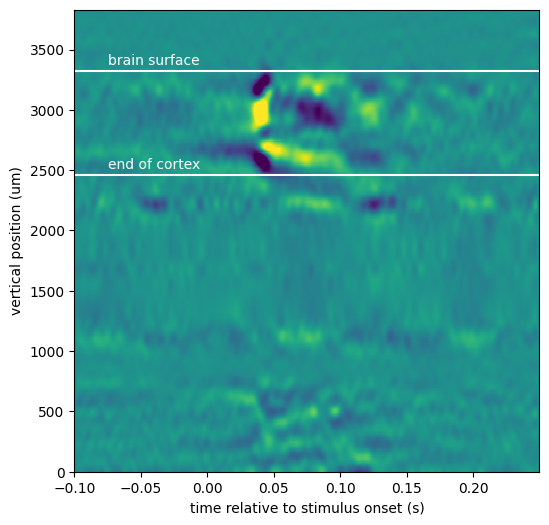

In [141]:
from scipy.ndimage.filters import gaussian_filter

_ = plt.figure(figsize=(10,10))

filtered_csd = gaussian_filter(csd.data, sigma=(5,1))

fig, ax = plt.subplots(figsize=(6, 6))

_ = ax.pcolor(csd["time"], csd["vertical_position"], filtered_csd, vmin=-3e4, vmax=3e4)

_ = ax.set_xlabel("time relative to stimulus onset (s)")
_ = ax.set_ylabel("vertical position (um)")


chans_in_v1 = chans[(chans['probe_id']==42)&(chans['structure_acronym'].str.contains('VISp'))]
last_cortex_channel_position = chans_in_v1['probe_vertical_position'].min()

ax.axhline(first_channel_in_brain_position, c='w')
ax.text(-0.075, first_channel_in_brain_position+50, 'brain surface', c='w')
ax.axhline(last_cortex_channel_position, c='w')
ax.text(-0.075, last_cortex_channel_position+50, 'end of cortex', c='w')